In [ ]:
import random
import numpy as np
from enum import Enum
from typing import Tuple, Sequence


class CellAction(Enum):
    NORTH = 0
    SOUTH = 1
    EAST = 2
    WEST = 3


ACTION_DELTA_MAP = {
    CellAction.WEST: (-1, 0),
    CellAction.EAST: (1, 0),
    CellAction.SOUTH: (0, 1),
    CellAction.NORTH: (0, -1),
}

SYMMETRIC_ACTION = {
    CellAction.NORTH: CellAction.SOUTH,
    CellAction.SOUTH: CellAction.NORTH,
    CellAction.EAST: CellAction.WEST,
    CellAction.WEST: CellAction.EAST,
}


class Cell:
    """A cell in the maze.

    A maze "Cell" is a point in the grid which may be surrounded by walls to
    the north, east, south or west.
    """

    def __init__(self, x: int, y: int):
        """Initialize the cell at (x,y). At first it is surrounded by walls."""
        self.x, self.y = x, y
        self.walls = {cell_action: True for cell_action in CellAction}
        self.exit = False
        self.entrance = False

    def mark_as_exit(self):
        """Define this cell as a maze exit."""
        self.exit = True

    def mark_as_entrance(self):
        """Define this cell as a maze entrance."""
        self.entrance = True

    def has_all_walls(self) -> bool:
        """Does this cell still have all its walls?"""
        return all(self.walls.values())

    def knock_down_wall(self, cell_action: CellAction):
        """Knock down the wall that would prevent us from carrying out cell_action."""
        self.walls[cell_action] = False


class Maze:
    """A Maze, represented as a grid of cells."""

    def __init__(
        self,
        nx: int,
        ny: int,
        ix: int = 0,
        iy: int = 0,
    ):
        """Initialize the maze grid.

        The maze consists of nx x ny cells and will be constructed starting
        at the cell indexed at (ix, iy).
        """
        assert 0 <= ix < nx
        assert 0 <= iy < ny
        self.nx, self.ny = nx, ny
        self.ix, self.iy = ix, iy
        self.maze_map = [[Cell(x, y) for y in range(ny)] for x in range(nx)]
        self.entrance_cell = self.cell_at(ix, iy)
        self.entrance_cell.mark_as_entrance()
        self.exit_cell = self._make_maze()

    def cell_at(self, x: int, y: int) -> Cell:
        """Return the Cell object at (x,y)."""

        return self.maze_map[x][y]

    def __str__(self):
        """Return a (crude) string representation of the maze."""

        maze_rows = ["-" * self.nx * 2]
        for y in range(self.ny):
            maze_row = ["|"]
            for x in range(self.nx):
                if self.maze_map[x][y].walls[CellAction.EAST]:
                    maze_row.append(" |")
                else:
                    maze_row.append("  ")
            maze_rows.append("".join(maze_row))
            maze_row = ["|"]
            for x in range(self.nx):
                if self.maze_map[x][y].walls[CellAction.SOUTH]:
                    maze_row.append("-+")
                else:
                    maze_row.append(" +")
            maze_rows.append("".join(maze_row))
        return "\n".join(maze_rows)

    def write_svg(self, filename: str):
        """Write an SVG image of the maze to filename."""

        aspect_ratio = self.nx / self.ny
        # Pad the maze all around by this amount.
        padding = 10
        # Height and width of the maze image (excluding padding), in pixels
        height = 500
        width = int(height * aspect_ratio)
        # Scaling factors mapping maze coordinates to image coordinates
        scy, scx = height / self.ny, width / self.nx

        def write_wall(file, ww_x1, ww_y1, ww_x2, ww_y2):
            """Write a single wall to the SVG image file handle f."""
            style = 'stroke="black" stroke-width="5"'
            print(
                '<line x1="{}" y1="{}" x2="{}" y2="{}" {} />'.format(
                    ww_x1, ww_y1, ww_x2, ww_y2, style
                ),
                file=file,
            )

        def write_cross(file, x, y):
            offset = 7
            style = 'stroke="blue" stroke-width="10"'
            print(
                '<line x1="{}" y1="{}" x2="{}" y2="{}" {} />'.format(
                    x - offset, y - offset, x + offset, y + offset, style
                ),
                file=file,
            )
            print(
                '<line x1="{}" y1="{}" x2="{}" y2="{}" {} />'.format(
                    x - offset, y + offset, x + offset, y - offset, style
                ),
                file=file,
            )

        def write_square(file, x, y):
            offset = 7
            style = 'stroke="green" stroke-width="10"'
            print(
                '<line x1="{}" y1="{}" x2="{}" y2="{}" {} />'.format(
                    x - offset, y - offset, x - offset, y + offset, style
                ),
                file=file,
            )
            print(
                '<line x1="{}" y1="{}" x2="{}" y2="{}" {} />'.format(
                    x - offset, y + offset, x + offset, y + offset, style
                ),
                file=file,
            )
            print(
                '<line x1="{}" y1="{}" x2="{}" y2="{}" {} />'.format(
                    x + offset, y + offset, x + offset, y - offset, style
                ),
                file=file,
            )
            print(
                '<line x1="{}" y1="{}" x2="{}" y2="{}" {} />'.format(
                    x + offset, y - offset, x - offset, y - offset, style
                ),
                file=file,
            )

        # Write the SVG image file for maze
        with open(filename, "w") as f:
            # SVG preamble and styles.
            print('<?xml version="1.0" encoding="utf-8"?>', file=f)
            print('<svg xmlns="http://www.w3.org/2000/svg"', file=f)
            print('    xmlns:xlink="http://www.w3.org/1999/xlink"', file=f)
            print(
                '    width="{:d}" height="{:d}" viewBox="{} {} {} {}">'.format(
                    width + 2 * padding,
                    height + 2 * padding,
                    -padding,
                    -padding,
                    width + 2 * padding,
                    height + 2 * padding,
                ),
                file=f,
            )
            print('<defs>\n<style type="text/css"><![CDATA[', file=f)
            print("line {", file=f)
            print("    stroke-width: 5;\n}", file=f)
            print("]]></style>\n</defs>", file=f)
            # Draw the "South" and "East" walls of each cell, if present (these
            # are the "North" and "West" walls of a neighbouring cell in
            # general, of course).
            for x in range(self.nx):
                for y in range(self.ny):
                    if self.cell_at(x, y).walls[CellAction.SOUTH]:
                        x1, y1 = x * scx, (y + 1) * scy
                        x2, y2 = (x + 1) * scx, (y + 1) * scy
                        write_wall(f, x1, y1, x2, y2)
                    if self.cell_at(x, y).walls[CellAction.EAST]:
                        x1, y1 = (x + 1) * scx, y * scy
                        x2, y2 = (x + 1) * scx, (y + 1) * scy
                        write_wall(f, x1, y1, x2, y2)
                    if self.cell_at(x, y).exit:
                        write_cross(f, (x + 0.5) * scx, (y + 0.5) * scy)
                    if self.cell_at(x, y).entrance:
                        write_square(f, (x + 0.5) * scx, (y + 0.5) * scy)
            # Draw the North and West maze border, which won't have been drawn
            # by the procedure above.
            style = 'stroke="black" stroke-width="5"'
            print(
                '<line x1="0" y1="0" x2="{}" y2="0" {} />'.format(width, style), file=f
            )
            print(
                '<line x1="0" y1="0" x2="0" y2="{}" {} />'.format(height, style), file=f
            )
            print("</svg>", file=f)

    def _get_transitions_to_unvisited_cell(
        self, cell: Cell
    ) -> Sequence[Tuple[CellAction, Cell]]:
        transitions = []
        for cell_action, (dx, dy) in ACTION_DELTA_MAP.items():
            x2, y2 = cell.x + dx, cell.y + dy
            if (0 <= x2 < self.nx) and (0 <= y2 < self.ny):
                neighbour_cell = self.cell_at(x2, y2)
                if neighbour_cell.has_all_walls():
                    transitions.append((cell_action, neighbour_cell))
        return transitions

    def _make_maze(
        self,
    ) -> Cell:
        # Total number of cells.
        n = self.nx * self.ny
        cell_stack = []
        current_cell = self.cell_at(self.ix, self.iy)
        # Total number of visited cells during maze construction.
        nv = 1
        # Minimum number of moves to get to the exit before randomly
        # knocking down walls
        min_nb_move = 0

        while nv < n:
            transitions = self._get_transitions_to_unvisited_cell(current_cell)

            if not transitions:
                # We've reached a dead end: backtrack.
                current_cell = cell_stack.pop()
                min_nb_move -= 1
                continue

            # Choose a random neighbouring cell and move to it.
            cell_action, next_cell = random.choice(transitions)
            current_cell.knock_down_wall(cell_action)
            next_cell.knock_down_wall(SYMMETRIC_ACTION[cell_action])
            cell_stack.append(current_cell)
            current_cell = next_cell
            nv += 1
            min_nb_move += 1

        # use last visited cell as maze exit
        exit_cell = current_cell
        exit_cell.mark_as_exit()

        return exit_cell




In [ ]:
#from maze_utils import Maze, Cell, CellAction, ACTION_DELTA_MAP


In [ ]:
# Maze dimensions (ncols, nrows)
nx, ny = 10, 10
# Maze entry position
ix, iy = 0, 0

maze = Maze(nx, ny, ix, iy)
print(
    f"The goal is to reach the cell {(maze.exit_cell.x, maze.exit_cell.y)} "
    f"from the starting cell {(maze.entrance_cell.x, maze.entrance_cell.y)} ")

The goal is to reach the cell (6, 2) from the starting cell (0, 0) 


In [ ]:
from IPython.display import SVG, display

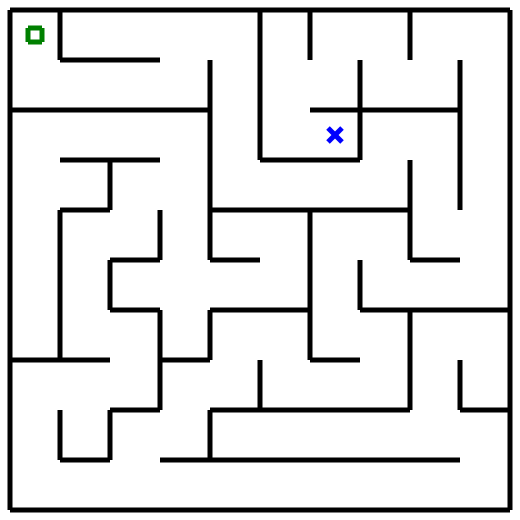

In [ ]:
maze.write_svg('maze.svg')
display(SVG('maze.svg'))

In [ ]:
for cell_action in CellAction:
    delta_x, delta_y = ACTION_DELTA_MAP[cell_action]
    print(f"{cell_action.name}: (x + {delta_x}, y + {delta_y})")

NORTH: (x + 0, y + -1)
SOUTH: (x + 0, y + 1)
EAST: (x + 1, y + 0)
WEST: (x + -1, y + 0)


In [ ]:
for cell_action in CellAction:
    forbidden = maze.entrance_cell.walls[cell_action]
    print(f"Going {cell_action.name} from the entrance is {'forbidden' if forbidden else 'allowed'}")

Going NORTH from the entrance is forbidden
Going SOUTH from the entrance is allowed
Going EAST from the entrance is forbidden
Going WEST from the entrance is forbidden


In [ ]:
# Here I will use recursion function inorder to determine the trajectory to reach the end of the maze.
# I defined visited matrix which will help me to know the visited and non-visited cells.
# therefore the complexity of the solution is defined by O(nm), where n & m are the length and width of the maze respectively.
# At the end you can see 4 testcases used to test my solution.

import numpy as np

def solve(maze,i,j,list,visited):
    if visited.item((j,i)) == 1:     # if the cell is already visited, then stop
        return False
    
    visited.itemset((j,i),1)                      # if the cell is not visited,replace in the visited matrix by 1
    if maze.cell_at(i,j).x == maze.exit_cell.x:   # if reached exit cell, return true => finished
        if maze.cell_at(i,j).y == maze.exit_cell.y:
            return True
        
    for cell_action in CellAction:
        delta_x, delta_y = ACTION_DELTA_MAP[cell_action]
        forbidden = maze.cell_at(i,j).walls[cell_action]
        if not forbidden:                                     # determine the available actions you can do
            if solve(maze,i+delta_x,j+delta_y,list,visited):  # look for a path recursionly
                list.append(cell_action.name)                 # when you found a path,add the action used to the list of actions
                return True
    return list               #return list of actions in reverse order

def ShortestPath(maze):
    l=[]
    visited=np.zeros((maze.ny,maze.nx))                   # initialize the visited vector as zeros (not visited)
    actions=solve(maze,maze.entrance_cell.x,maze.entrance_cell.y,l,visited)      #return list of action in reverse order
    l.reverse()                   #reverse the list of actions
    print(l)
    return

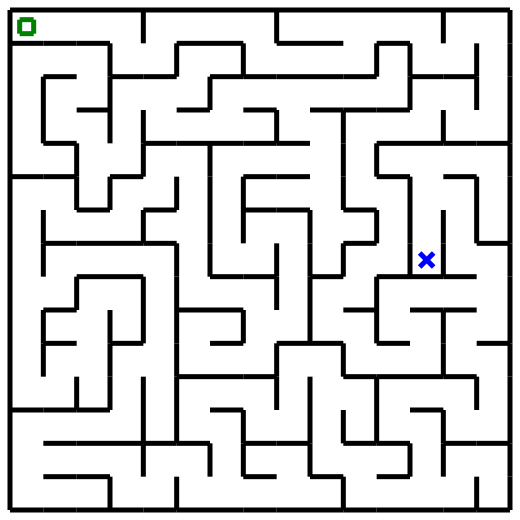

['EAST', 'EAST', 'EAST', 'SOUTH', 'EAST', 'NORTH', 'EAST', 'EAST', 'EAST', 'SOUTH', 'EAST', 'EAST', 'EAST', 'NORTH', 'EAST', 'EAST', 'SOUTH', 'EAST', 'NORTH', 'EAST', 'SOUTH', 'SOUTH', 'SOUTH', 'WEST', 'NORTH', 'WEST', 'SOUTH', 'WEST', 'WEST', 'SOUTH', 'SOUTH', 'EAST', 'SOUTH', 'SOUTH', 'WEST', 'SOUTH', 'WEST', 'SOUTH', 'EAST', 'SOUTH', 'EAST', 'EAST', 'NORTH', 'WEST', 'NORTH', 'EAST', 'EAST', 'EAST', 'NORTH', 'WEST', 'NORTH', 'NORTH', 'WEST', 'SOUTH', 'SOUTH']


In [ ]:
# Maze dimensions (ncols, nrows)
nx1, ny1 = 15, 15
# Maze entry position
ix1, iy1 = 0, 0

maze1 = Maze(nx1, ny1, ix1, iy1)
maze1.write_svg('maze1.svg')
display(SVG('maze1.svg'))
ShortestPath(maze1)